# House price prediction using linear regression 

Using the boston housing dataset: https://www.kaggle.com/c/boston-housing/

In [ ]:
# Imports
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & Data loaders

In [ ]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

  0%|          | 0/35735 [00:00<?, ?it/s]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [ ]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [ ]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = HousingModel()

## Training

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 1074.8275146484375}

In [ ]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 758.0631
Epoch [1], val_loss: 616.3926
Epoch [2], val_loss: 429.7154
Epoch [3], val_loss: 318.8142
Epoch [4], val_loss: 253.7685
Epoch [5], val_loss: 219.8415
Epoch [6], val_loss: 174.7628
Epoch [7], val_loss: 145.9045
Epoch [8], val_loss: 127.4187
Epoch [9], val_loss: 112.1065


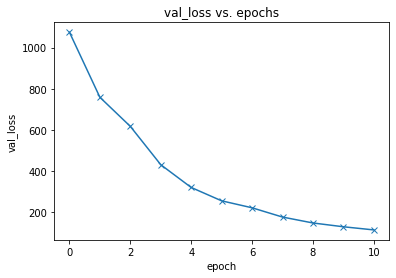

In [ ]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [ ]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(xb).item()

In [ ]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([2.7630e-02, 7.5000e+01, 2.9500e+00, 0.0000e+00, 4.2800e-01, 6.5950e+00,
        2.1800e+01, 5.4011e+00, 3.0000e+00, 2.5200e+02, 1.8300e+01, 3.9563e+02,
        4.3200e+00])
Target:  30.799999237060547
Prediction: 25.224905014038086
